# Final Report  

### **Annabel Lim, Owen Kwong, Yash Mali, Yui Mikuriya (Group 20)**

## Introduction



Higher education institutions worldwide are attempting to effectively address diverse student learning styles and academic performances to enhance the learning experience. One interesting topic to consider is the dropout rate within higher education along with exploration of its root causes. A key factor that affects college graduation rates is that students with better academic performance in high school are more likely to graduate from college. 

The goal of this project is to determine if students who dropped out had lower admission grades than the students who graduated. The Polytechnic Institute of Portalegre (IPP) has a dataset with student data from four schools in Portugal. It provides data on nationality, admission grades, and graduation status. To explore this goal, we have formulated the below research question:

**Research Question:** *Research Question: Is there enough evidence to suggest that admission grades of students who dropped out are lower than students who graduated?*

## Methods and Results

In the plimenary results on the project proposal, we identified that the distribution of the sample was normally distributed.
We were also able to identify the point estimate for the mean in both the drop-outs and the graduated.


We plan to conduct a one-sided hypothesis test to examine if there is enough evidence to suggest that the admission grades of dropout students are lower than graduated students. This can be represented in the following hypothesis where $m_1$ is the mean admission grade of dropout students and $m_2$ is the mean admission grade of graduated students.

$H_0: m_1-m_2 = 0$

$H_1: m_1-m_2 < 0$

**Method outline:**
- Find point estimate
- Use the infer workflow to simulate from the null distribution
- Conduct hypothesis test with p-value using $\alpha = 0.05$
- To access results, use bootstrapping method and conduct hypothesis test with a 95% CI
- Compare and interpret results of the p-value and CI 

We start by loading libraries, setting the seed, and importing the dataset into a dataframe.

In [1]:
# load libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(datateachr)

# set seed
set.seed(2023);

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# data url (zip file)
url <- "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"

# unzip and load data
temp <- tempfile()
download.file(url,temp)
dropout_data <- read.csv2(unz(temp, "data.csv")) 
unlink(temp)

#Clean the data 
dropout_clean <- dropout_data %>% rename(Student_Status = Target, 
                                         Admission_Grade = Admission.grade) %>% #Rename 'Target' column
  mutate(Student_Status = as_factor(Student_Status)) %>% #Convert the 'Student_Status' column to a factor
  filter(Student_Status != "Enrolled") 

#Select only the Target column 
dropout_pop <- dropout_clean %>% select(Student_Status, Admission_Grade) %>%
    mutate(Admission_Grade = as.numeric(Admission_Grade))

head(dropout_pop)

,Student_Status,Admission_Grade
,<fct>,<dbl>
1,Dropout,127.3
2,Graduate,142.5
3,Dropout,124.8
4,Graduate,119.6
5,Graduate,141.5
6,Graduate,114.8


### Getting Point Estimate

In [3]:
estimate = dropout_pop |> group_by(Student_Status) |> summarize(point_estimate = mean(Admission_Grade))
estimate

Student_Status,point_estimate
<fct>,<dbl>
Dropout,124.9614
Graduate,128.7944


## Our Hypothesis - 

$H_0: m_d-m_g = 0$

$H_1: m_d-m_g < 0$

At signifiance level is $\alpha = 5%$.

Here $m_d$ is the mean grade of the dropout candiates and $m_g$ is the mean grade of graduate candidates. We will use 2 approaches, simulation and theory based.



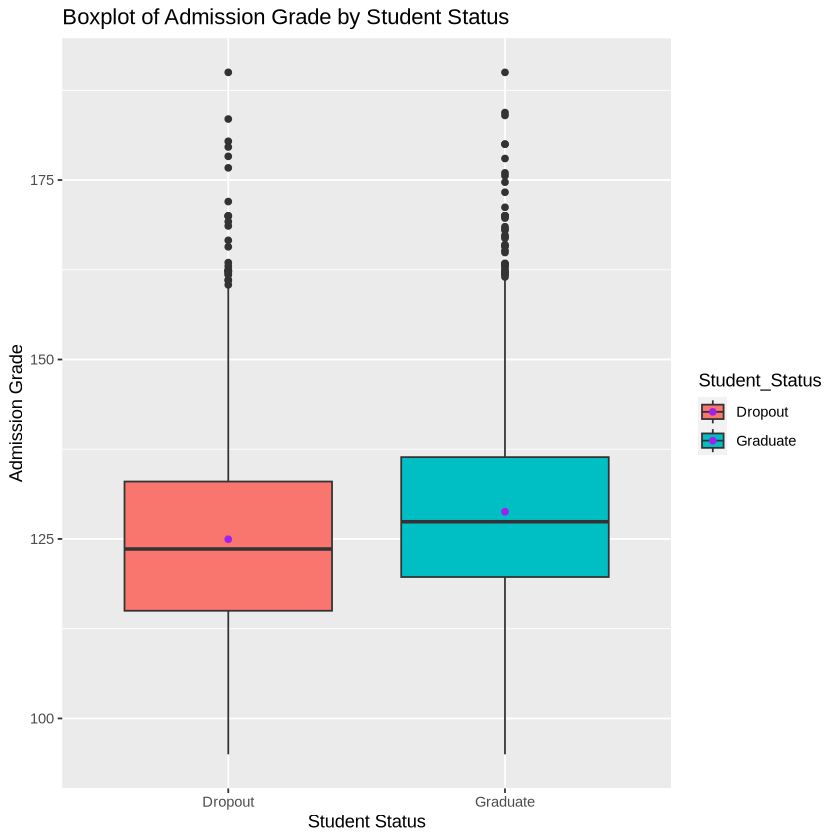

In [4]:
boxplot <-
    ggplot(dropout_pop, aes(x=Student_Status,y=Admission_Grade, fill=Student_Status)) + geom_boxplot() +
    stat_summary(fun = "mean", geom = "point", color = "purple") + 
    labs(title = "Boxplot of Admission Grade by Student Status",
    x = "Student Status",
    y = "Admission Grade")
boxplot

### Simulation based approach - 

We will calculate the overserved test statistic with the `infer` package. 
`dropout_pop` will be used to specify the repsonse and explanatory variables and calculate Graduate’s admission mean minus Dropout’s admission mean. 

In [5]:
test_stat <- dropout_pop %>%
  specify(Admission_Grade ~ Student_Status) %>%                         # Specifying the model.
  calculate(stat = "diff in means", order = c("Dropout", "Graduate"))   # Calculating the statistic.

test_stat

Dropping unused factor levels Enrolled from the supplied explanatory variable 'Student_Status'.


stat
<dbl>
-3.833067


**Simulating from the null distribution**

We then generate 1000 samples from the null distribution using the `infer` package. We used `dropout_pop` to specify the response and explanatory variables, hypothesize, generate 1000 samples and calculate Dropout’s mean minus Graduate’s median.

In [6]:
set.seed(2023);

null_dist <- dropout_pop %>%
  specify(Admission_Grade ~ Student_Status) %>%
  hypothesize(null="independence") %>%
  generate(type="permute", reps = 1000) %>%
  calculate(stat = "diff in means", order = c("Dropout", "Graduate"))

head(null_dist)

Dropping unused factor levels Enrolled from the supplied explanatory variable 'Student_Status'.


replicate,stat
<int>,<dbl>
1,-0.1846668
2,0.2266730
3,0.1713959
4,-0.2688544
5,0.4505565
6,0.4322850


Now, we plot the result of our hypothesis test. The red vertical bar shoes the position of the observed test statistic. 

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


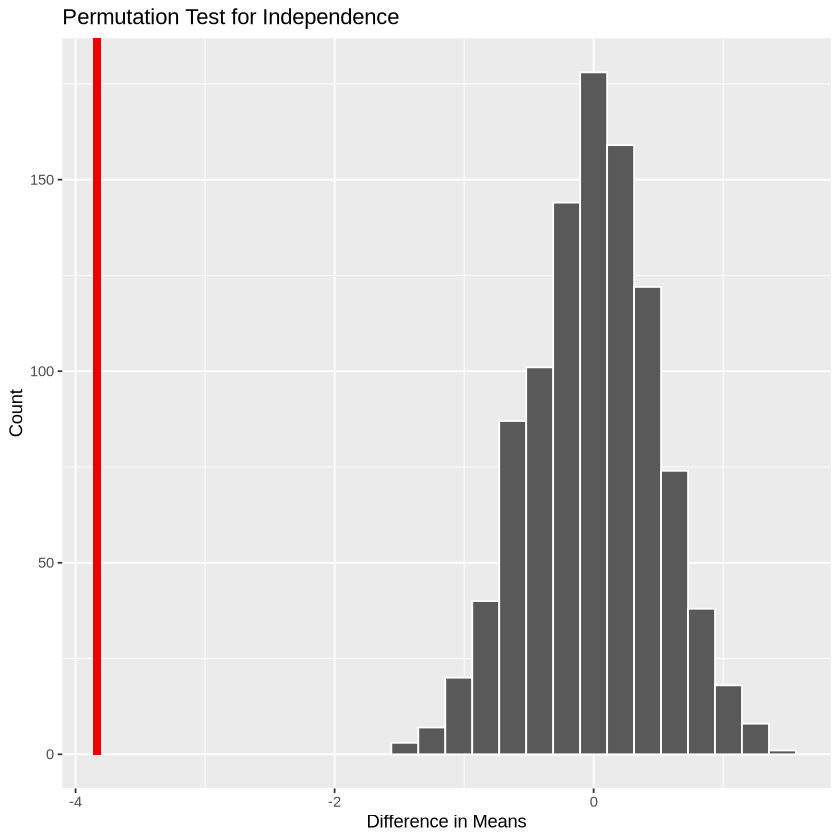

In [17]:
null_dist_plot <- null_dist %>%
  visualize() +
  shade_p_value(obs_stat = test_stat, direction = "left") + 
  labs(title = "Permutation Test for Independence",
             x = "Difference in Means",
             y = "Count")
null_dist_plot

We calculate the p-value for the test statistic from the null distribution to determine whether or not we will reject the null hypothesis.

In [18]:
p_value <- null_dist %>%
  get_p_value(obs_stat = test_stat, direction = "left")

p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


Because our p-value is extremely small and close to 0, it implies that the probability of making a Type 1 error is very small.
The p-value $\le \alpha = 0.05$. This suggest that we should reject $H_o$

Now, we will find the 95% confidence interval for the difference in the means.

Dropping unused factor levels Enrolled from the supplied explanatory variable 'Student_Status'.


lower_ci,upper_ci
<dbl>,<dbl>
-4.813014,-2.842553


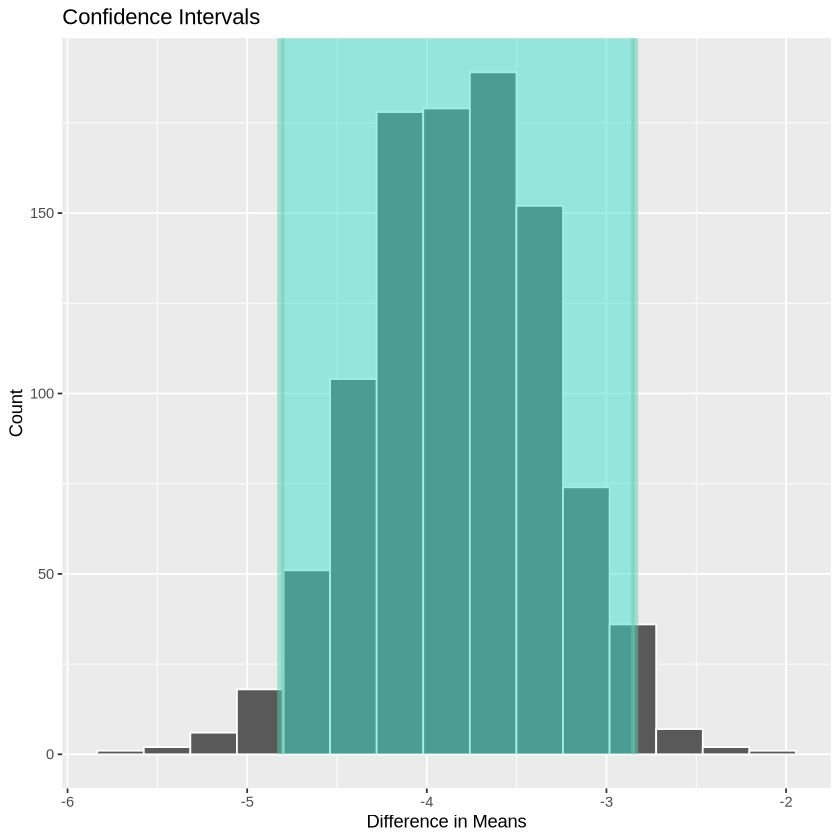

In [21]:
bootstrap_dist <- dropout_pop %>%
  specify(Admission_Grade ~ Student_Status) %>%
  generate(type="bootstrap", reps = 1000) %>%
  calculate(stat = "diff in means", order = c("Dropout", "Graduate"))

ci <- bootstrap_dist %>%
  get_ci(level = 0.95, type="percentile")
ci

bootstrap_dist_ci_plot <- bootstrap_dist %>%
  visualize() +
  shade_ci(endpoints = ci, alpha=0.5) + xlab("Means Difference") + 
  labs(title = "Confidence Intervals",
             x = "Difference in Means",
             y = "Count")
bootstrap_dist_ci_plot

Based on the visualization and the p-value, the p-value $\le \alpha = 0.05$. We can conclude that there is enough statistical evidence to suggest that the mean admission grade is higher for Graduated students than Dropout students. 

### Theory based approach to two sample t-test

The assumptions we are making to go through with the theory based approach using CLT are as follows: 
1. **Random Sampling**: 
2. **Independent Samples**: 
3. **Large Sample Size**: The sizes of our samples for both the dropout students and the graduated students are large enough for the Central Limit Theorem to apply. 

Therefore, we can approximate the null model to the t-distribution with $v$ degrees of freedom. 

The test statistic can be described as: 
$$
T = \frac{\bar{x}_d-\bar{x}_g}{\sqrt{\frac{s_d^2}{n_d} + \frac{s_g^2}{n_g}} }
$$


With the null model having degrees of freedom: 
$$
v = \frac{
    \left(\frac{s_d^2}{n_d}+\frac{s_g^2}{n_g}\right)^2
}
{
\frac{s_d^4}{n_d^2(n_d-1)}+\frac{s_g^4}{n_g^2(n_g-1)}
}
$$

In [10]:
# Grouping scores for dropout and graduates 
group_d <- filter(dropout_pop, Student_Status == "Dropout")$Admission_Grade
group_g <- filter(dropout_pop, Student_Status == "Graduate")$Admission_Grade

The p-value for this hypothesis test can be retrieved in R multiple ways (through t.test or manually) and will be the same for both.

In [11]:
# through t.test
test_t_test <- 
    broom::tidy(
        t.test(x = group_d, y = group_g,
               alternative = "less")
    )

p_value_T = test_t_test[1,5] %>% 
            pull()

cat("p-value from t.test() function :", p_value_T) 

p-value from t.test() function : 1.296433e-14

In [12]:
# through algebra

mean_d <- mean(group_d)
mean_g <- mean(group_g)
sd_d <- sd(group_d)
sd_g <- sd(group_g)
n_d <- length(group_d)
n_g <- length(group_g)


# test statistic for two sample t-test
t_value <- (mean_d - mean_g) / sqrt((sd_d^2 / n_d) + (sd_g^2 / n_g))

# degrees of freedom for two sample t-test
freedom <- ((sd_d^2/n_d)+(sd_g^2/n_g))^2/((sd_d^4/(n_d^2*(n_d-1)))+(sd_g^4/(n_g^2*(n_g-1))))

# p-value
p_val_manual <- pt(t_value, df = freedom)

cat("p-value manually computed:", p_val_manual, "\n")

p-value manually computed: 1.296433e-14 


As we can see, the p-value is close to 0. So clearly the p-value $\le \alpha = 0.05$. This gives us reason to suggest that we should reject $H_o$ in favour of $H_a$

This suggests that there is a statistically significant difference between the addmission grade of a dropout and graduate and we have enough evidence to suggest that graduates do have a higher admission grade at a significance level $5$%    

### Theory base approach to the confidence interval

Furthermore, given that the data meets the assumptions for a two sample t-test (randomness, independence, and large sample sizes) a 95% confidence interval for the difference in means can be created using: 
$$
CI = (\bar{x}_d - \bar{x}_g) \pm t^* \sqrt{\frac{s_d^2}{n_d}+\frac{s_g^2}{n_g}}
$$
Where $t^*$ is the critical value from the t-distribution with a 95% significance level and $v$ degrees of freedom.

In [13]:
# t critical value for 95% confidence 
t_critical <- qt(0.975, df=freedom)

# lower and upper bounds of the confidence interval
theory_ci <- tibble(
ci_lower = (mean_d - mean_g) - t_critical * sqrt(sd_d^2/n_d+sd_g^2/n_g),
ci_upper = (mean_d - mean_g) + t_critical * sqrt(sd_d^2/n_d+sd_g^2/n_g)
)

theory_ci

ci_lower,ci_upper
<dbl>,<dbl>
-4.814693,-2.85144


Figure ?. 95% confidence interval for the mean difference between dropout and graduated students. 

Therefore, we are 95% confident that the true mean difference between the admission grades of dropout students and graduated students is between -4.815 and -2.851 points on the standardized score.

## Discussion

## Refrences

Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís. (2021). Predict students' dropout and academic success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.

Kantrowitz, M. (2021, November 19). Shocking statistics about college graduation rates. Forbes. https://www.forbes.com/sites/markkantrowitz/2021/11/18/shocking-statistics-about-college-graduation-rates/?sh=162e8c1f2b69

Chester Ismay and Albert Y. Kim. A ModernDive into R and the Tidyverse. https://moderndive.com/index.html